# Aggregating Population Change and Migration Types for Franklin and Delaware Counties from Census PEP data

## Introduction

This script is meant to take county-wide Census Pep data and filter for Franklin and Delaware from 2010-2021 and output two new agregated tables, one to focus on migration type and the other population change type, where the trends between the counties are combined.

### Process outline

The process carried out by this workflow can be described as follows:
  - The script will retrieve the Census PEP datasets from the local MORPC repo
  - Filter to only retain and sum records from Franklin or Delawre, Ohio 2010-2021
  - Identify and keep only the rows containing the maximum 'Vintage' for each 'Year'
  - Transform tables to aggregate migration information by type and aggregate population change information by type.
  - Write aggregated tables and stacked bar charts to Excel to distingush between international and domestic migration and another to distinguish between natrual population change and net migration

## Setup

### Import required packages

In [2]:
import csv
import os
import shutil
import json
from tableschema import Table
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from frictionless import Detector, describe, validate, Schema
import sys
sys.path.append(os.path.normpath("../morpc-common"))
import morpc

### Parameters

In [3]:
# Assign a color to each of the expected bars in the chart using hex codes.
BAR_COLORS={
        "DOMESTICMIG":morpc.CONST_MORPC_COLORS["midblue"],
        "NETMIG":morpc.CONST_MORPC_COLORS["midblue"],
        "NATURALCHG":morpc.CONST_MORPC_COLORS["bluegreen"],
        "INTERNATIONALMIG":morpc.CONST_MORPC_COLORS["bluegreen"] 
}
# Specify the number formatting string to be used on the y-axis of the charts
# NUMBER_FORMAT_STRING = '[>=1000]#,##0,"K";'

# Define input and output directories
INPUT_DIR = "./input_data"
OUTPUT_DIR = "./output_data"

### Define inputs

#### Census Pep country wide table

In [4]:
CENSUSPEP_COUNTY_WIDE_TABLE_FILENAME = "censusPep_county_wide.csv"
CENSUSPEP_COUNTY_WIDE_TABLE_PATH = os.path.join(INPUT_DIR, CENSUSPEP_COUNTY_WIDE_TABLE_FILENAME)
CENSUSPEP_COUNTY_WIDE_TABLE_SCHEMA_FILENAME = CENSUSPEP_COUNTY_WIDE_TABLE_FILENAME.replace(".csv","_schema.json")
CENSUSPEP_COUNTY_WIDE_TABLE_SCHEMA_PATH = os.path.join(INPUT_DIR, CENSUSPEP_COUNTY_WIDE_TABLE_SCHEMA_FILENAME)
CENSUSPEP_COUNTY_WIDE_TABLE_METADATA_FILENAME = CENSUSPEP_COUNTY_WIDE_TABLE_FILENAME.replace(".csv","_metadata.yaml")
CENSUSPEP_COUNTY_WIDE_TABLE_METADATA_PATH = os.path.join(INPUT_DIR, CENSUSPEP_COUNTY_WIDE_TABLE_METADATA_FILENAME)
print("Data: {}".format(CENSUSPEP_COUNTY_WIDE_TABLE_PATH))
print("Schema: {}".format(CENSUSPEP_COUNTY_WIDE_TABLE_SCHEMA_PATH))
print("Metadata: {}".format(CENSUSPEP_COUNTY_WIDE_TABLE_METADATA_PATH))

Data: ./input_data\censusPep_county_wide.csv
Schema: ./input_data\censusPep_county_wide_schema.json
Metadata: ./input_data\censusPep_county_wide_metadata.yaml


### Define outputs

#### Franklin and Delaware counties migration by type and year (2010-2021)

In [5]:
MIGRATION_TABLE_FILENAME = "migration_aggregated_data.csv"
MIGRATION_TABLE_PATH = os.path.join(OUTPUT_DIR, MIGRATION_TABLE_FILENAME)
MIGRATION_TABLE_SCHEMA_FILENAME = MIGRATION_TABLE_FILENAME.replace(".csv","_schema.json")
MIGRATION_TABLE_SCHEMA_PATH = os.path.join(OUTPUT_DIR, MIGRATION_TABLE_SCHEMA_FILENAME)
MIGRATION_TABLE_METADATA_FILENAME = MIGRATION_TABLE_FILENAME.replace(".csv","_metadata.yaml")
MIGRATION_TABLE_METADATA_PATH = os.path.join(OUTPUT_DIR, MIGRATION_TABLE_METADATA_FILENAME)
print("Data: {}".format(MIGRATION_TABLE_PATH))
print("Schema: {}".format(MIGRATION_TABLE_SCHEMA_PATH))
print("Metadata: {}".format(MIGRATION_TABLE_METADATA_PATH))

Data: ./output_data\migration_aggregated_data.csv
Schema: ./output_data\migration_aggregated_data_schema.json
Metadata: ./output_data\migration_aggregated_data_metadata.yaml


#### Franklin and Delaware counties population change by type and year (2010-2021)

In [6]:
POPCHANGE_TABLE_FILENAME = "popChange_aggregated_data.csv"
POPCHANGE_TABLE_PATH = os.path.join(OUTPUT_DIR, POPCHANGE_TABLE_FILENAME)
POPCHANGE_TABLE_SCHEMA_FILENAME = POPCHANGE_TABLE_FILENAME.replace(".csv","_schema.json")
POPCHANGE_TABLE_SCHEMA_PATH = os.path.join(OUTPUT_DIR, POPCHANGE_TABLE_SCHEMA_FILENAME)
POPCHANGE_TABLE_METADATA_FILENAME = POPCHANGE_TABLE_FILENAME.replace(".csv","_metadata.yaml")
POPCHANGE_TABLE_METADATA_PATH = os.path.join(OUTPUT_DIR, POPCHANGE_TABLE_METADATA_FILENAME)
print("Data: {}".format(POPCHANGE_TABLE_PATH))
print("Schema: {}".format(POPCHANGE_TABLE_SCHEMA_PATH))
print("Metadata: {}".format(POPCHANGE_TABLE_METADATA_PATH))

Data: ./output_data\popChange_aggregated_data.csv
Schema: ./output_data\popChange_aggregated_data_schema.json
Metadata: ./output_data\popChange_aggregated_data_metadata.yaml


#### Compiled Excel sheet

In [7]:
OUTPUT_TABLE_FILENAME = "compiled.xlsx"
OUTPUT_TABLE_PATH = os.path.join(OUTPUT_DIR, OUTPUT_TABLE_FILENAME)
print("Output data path: {}".format(OUTPUT_TABLE_PATH))

Output data path: ./output_data\compiled.xlsx


## Create Census Pep table and schema in input path

### Validating Census Pep country wide table

In [8]:
# Adjust the path to where the .csv table and .json schema are located
table_path = "../morpc-censuspep-fetch/output_data/censusPep_county_wide.csv"

# Read the CSV file into a DataFrame
data = pd.read_csv(table_path, index_col=0)

# Identify columns with no names (empty strings or NaN) and drop them
data = data.loc[:, data.columns[data.columns != '']]

# Preview data with frictionless
resource = describe(data)
pprint(resource)

# Detect missing values in table
detector = Detector(field_missing_values=["", "n/a"])
resource = describe(data, detector=detector)
resource.to_yaml(CENSUSPEP_COUNTY_WIDE_TABLE_METADATA_PATH)
with open(CENSUSPEP_COUNTY_WIDE_TABLE_METADATA_PATH) as file:
    print(file.read())

# Validate data
report = validate(CENSUSPEP_COUNTY_WIDE_TABLE_METADATA_PATH)
pprint(report.flatten(["rowNumber", "fieldNumber", "type"]))

{'name': 'memory',
 'type': 'table',
 'data': [],
 'format': 'pandas',
 'mediatype': 'application/pandas',
 'schema': {'fields': [{'name': 'GEOID',
                        'type': 'integer',
                        'constraints': {'required': True}},
                       {'name': 'STNAME', 'type': 'string'},
                       {'name': 'CTYNAME', 'type': 'string'},
                       {'name': 'Year', 'type': 'integer'},
                       {'name': 'Vintage', 'type': 'integer'},
                       {'name': 'BIRTHS', 'type': 'integer'},
                       {'name': 'DEATHS', 'type': 'integer'},
                       {'name': 'DOMESTICMIG', 'type': 'integer'},
                       {'name': 'INTERNATIONALMIG', 'type': 'integer'},
                       {'name': 'NATURALCHG', 'type': 'integer'},
                       {'name': 'NETMIG', 'type': 'integer'},
                       {'name': 'NPOPCHG', 'type': 'integer'},
                       {'name': 'POPESTIMATE', 't

In [9]:
# Save the census data to the input directory
data.to_csv(CENSUSPEP_COUNTY_WIDE_TABLE_PATH)

# Validate saved .csv
report = validate(CENSUSPEP_COUNTY_WIDE_TABLE_PATH)
pprint(report.flatten(["rowNumber", "fieldNumber", "type"]))

[]


### Creating Census Pep country wide table schema to input directory with Table Schema

In [10]:
# Table Schema using Frictionless
schema = Schema.describe(data)
schema.to_yaml(CENSUSPEP_COUNTY_WIDE_TABLE_METADATA_PATH)

with open(CENSUSPEP_COUNTY_WIDE_TABLE_METADATA_PATH) as file:
    print(file.read())

# Create table
table = Table(CENSUSPEP_COUNTY_WIDE_TABLE_PATH)

# Infer table variable types
table.infer()

# Convert missing values to 'N/A'
table.schema.descriptor['missingValues'] = ['N/A', '']
table.schema.commit()

# Save schema
table.schema.save(CENSUSPEP_COUNTY_WIDE_TABLE_SCHEMA_PATH)

fields:
  - name: GEOID
    type: integer
    constraints:
      required: true
  - name: STNAME
    type: string
  - name: CTYNAME
    type: string
  - name: Year
    type: integer
  - name: Vintage
    type: integer
  - name: BIRTHS
    type: integer
  - name: DEATHS
    type: integer
  - name: DOMESTICMIG
    type: integer
  - name: INTERNATIONALMIG
    type: integer
  - name: NATURALCHG
    type: integer
  - name: NETMIG
    type: integer
  - name: NPOPCHG
    type: integer
  - name: POPESTIMATE
    type: integer
  - name: RESIDUAL
    type: integer
primaryKey:
  - GEOID



### Converting input table variables from schema

In [11]:
# Load the schema from the JSON file
with open(CENSUSPEP_COUNTY_WIDE_TABLE_SCHEMA_PATH, 'r') as file:
    schema = json.load(file)

# Define a function to convert data types based on the schema
def convert_data_types(row, schema):
    converted_row = {}
    for field in schema['fields']:
        field_name = field['name']
        field_type = field['type']
        if field_name in row:
            if field_type == 'int':
                converted_row[field_name] = int(row[field_name])
            elif field_type == 'string':
                converted_row[field_name] = str(row[field_name])
            # Add more type conversions as needed
            else:
                converted_row[field_name] = row[field_name]  # Keep as is if type not recognized
    return converted_row

# Read the input data, apply conversion, and process it
converted_data = []

with open(CENSUSPEP_COUNTY_WIDE_TABLE_PATH, 'r') as csvfile:
    reader = csv.DictReader(csvfile) #change to pandas
    for row in reader:
        converted_row = convert_data_types(row, schema)
        converted_data.append(converted_row)

## Filtering for and combining Franklin, Ohio and Delaware, Ohio 2010-2021 with maximum vintage for each year

### Filter for maximum vintage for each year

In [12]:
# Step 1: Group by 'Year' and identify the maximum 'Vintage' for each 'Year'
max_vintage_per_year = data.groupby('Year')['Vintage'].transform("max")

# Step 2: Filter the original DataFrame to keep only rows with the maximum 'Vintage' for their 'Year'
data = data[data['Vintage'] == max_vintage_per_year]

### Filter for Ohio

In [13]:
# Filter for STNAME "Ohio"
data = data[data['STNAME'].isin(['Ohio'])]

### Filter for Delaware and Franklin counties

In [14]:
# Filter for CITYNAME "Delaware" and "Franklin"
data = data[data['CTYNAME'].isin(['Delaware', 'Franklin'])]

### Filter for 2010-2021

In [15]:
# Filter for Years between 2010-2021
data = data[(data['Year'] >= 2010) & (data['Year'] <= 2021)]

### Combine records between Franklin and Delaware counties for each year

In [16]:
# Group by 'YEAR' and calculate sums for the specified columns
data = data.groupby('Year').agg(
    BIRTHS=pd.NamedAgg(column='BIRTHS', aggfunc='sum'),
    DEATHS=pd.NamedAgg(column='DEATHS', aggfunc='sum'),
    DOMESTICMIG=pd.NamedAgg(column='DOMESTICMIG', aggfunc='sum'),
    INTERNATIONALMIG=pd.NamedAgg(column='INTERNATIONALMIG', aggfunc='sum'),
    NATURALCHG=pd.NamedAgg(column='NATURALCHG', aggfunc='sum'),
    NETMIG=pd.NamedAgg(column='NETMIG', aggfunc='sum'),
    NPOPCHG=pd.NamedAgg(column='NPOPCHG', aggfunc='sum'),
    POPESTIMATE=pd.NamedAgg(column='POPESTIMATE', aggfunc='sum'),
    RESIDUAL=pd.NamedAgg(column='RESIDUAL', aggfunc='sum')
).reset_index() 
data.head()

,Year,BIRTHS,DEATHS,DOMESTICMIG,INTERNATIONALMIG,NATURALCHG,NETMIG,NPOPCHG,POPESTIMATE,RESIDUAL
0,2010,5063,2216,-103,1000,2847,897,3653,1341301,-91
1,2011,19950,9502,2939,4642,10448,7581,18034,1359335,5
2,2012,20237,9469,4585,5555,10768,10140,20837,1380172,-71
3,2013,20791,9926,5614,7564,10865,13178,24086,1404258,43
4,2014,21122,9865,5784,6489,11257,12273,23544,1427802,14


## Creating migration change type table and schema

### Aggregation for migration type table

In [17]:
# Melt the DataFrame to "unpivot" the Total_DomesticMig and Total_InternationalMig columns
migration_data = pd.melt(data, id_vars=['Year'], value_vars=['DOMESTICMIG', 'INTERNATIONALMIG'], var_name='ChangeType', value_name='PopChange')

migration_data['ChangeType'] = migration_data['ChangeType'].map({'DOMESTICMIG': 'DOMESTICMIG', 'INTERNATIONALMIG': 'INTERNATIONALMIG'})

# Sort by 'Year'
migration_data_sorted = migration_data.sort_values(by='Year')

### Validating table

In [18]:
# Identify columns with no names (empty strings or NaN) and drop them
migration_data_sorted = migration_data_sorted.loc[:, migration_data_sorted.columns[migration_data_sorted.columns != '']]

# Preview data with frictionless
resource = describe(migration_data_sorted)
pprint(resource)

# Detect missing values in table
detector = Detector(field_missing_values=["", "n/a"])
resource = describe(migration_data_sorted, detector=detector)
resource.to_yaml(MIGRATION_TABLE_METADATA_PATH)
with open(MIGRATION_TABLE_METADATA_PATH) as file:
    print(file.read())

# Validate data
report = validate(migration_data_sorted)
pprint(report.flatten(["rowNumber", "fieldNumber", "type"]))

# Save the DataFrame to output directory
migration_data_sorted.to_csv(MIGRATION_TABLE_PATH, index=False)

{'name': 'memory',
 'type': 'table',
 'data': [],
 'format': 'pandas',
 'mediatype': 'application/pandas',
 'schema': {'fields': [{'name': 'Year', 'type': 'integer'},
                       {'name': 'ChangeType', 'type': 'string'},
                       {'name': 'PopChange', 'type': 'integer'}]}}
name: memory
type: table
data: []
format: pandas
mediatype: application/pandas
schema:
  fields:
    - name: Year
      type: integer
    - name: ChangeType
      type: string
    - name: PopChange
      type: integer

[]


### Creating migration type table schema

In [19]:
# Create table
table = Table(MIGRATION_TABLE_PATH)

# Infer table variable types
table.infer()

# Convert missing values to 'N/A'
table.schema.descriptor['missingValues'] = ['N/A', '']
table.schema.commit()

# Save schema
table.schema.save(MIGRATION_TABLE_SCHEMA_PATH)

### Converting migration type table variables from schema

In [20]:
# Load the schema from the JSON file
with open(MIGRATION_TABLE_SCHEMA_PATH, 'r') as file:
    schema = json.load(file)

# Define a function to convert data types based on the schema
def convert_data_types(row, schema):
    converted_row = {}
    for field in schema['fields']:
        field_name = field['name']
        field_type = field['type']
        if field_name in row:
            if field_type == 'int':
                converted_row[field_name] = int(row[field_name])
            elif field_type == 'string':
                converted_row[field_name] = str(row[field_name])
            # Add more type conversions as needed
            else:
                converted_row[field_name] = row[field_name]  # Keep as is if type not recognized
    return converted_row

# Read the input data, apply conversion, and process it
converted_data = []

with open(MIGRATION_TABLE_PATH, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        converted_row = convert_data_types(row, schema)
        converted_data.append(converted_row)

In [21]:
# Preview migration change type table
df = pd.read_csv(MIGRATION_TABLE_PATH)
df.head()

,Year,ChangeType,PopChange
0,2010,DOMESTICMIG,-103
1,2010,INTERNATIONALMIG,1000
2,2011,DOMESTICMIG,2939
3,2011,INTERNATIONALMIG,4642
4,2012,DOMESTICMIG,4585


## Creating population change type table and schema

### Aggregation for population change type table

In [22]:
# Melt the DataFrame to "unpivot" the Total_NaturalChg and Total_NetMig columns
popChange_data = pd.melt(data, id_vars=['Year'], value_vars=['NATURALCHG', 'NETMIG'], var_name='ChangeType', value_name='PopChange')

popChange_data['ChangeType'] = popChange_data['ChangeType'].map({'NATURALCHG': 'NATURALCHG', 'NETMIG': 'NETMIG'})

# Sort by 'Year'
popChange_data_sorted = popChange_data.sort_values(by='Year')

### Validating Population Change Table

In [23]:
# Identify columns with no names (empty strings or NaN) and drop them
popChange_data_sorted = popChange_data_sorted.loc[:, popChange_data_sorted.columns[popChange_data_sorted.columns != '']]

# Preview data with frictionless
resource = describe(popChange_data_sorted)
pprint(resource)

# Detect missing values in table
detector = Detector(field_missing_values=["", "n/a"])
resource = describe(popChange_data_sorted, detector=detector)
resource.to_yaml(POPCHANGE_TABLE_METADATA_PATH)
with open(POPCHANGE_TABLE_METADATA_PATH) as file:
    print(file.read())

# Validate data
report = validate(popChange_data_sorted)
pprint(report.flatten(["rowNumber", "fieldNumber", "type"]))

# Save the DataFrame to output directory
popChange_data_sorted.to_csv(POPCHANGE_TABLE_PATH, index=False)

{'name': 'memory',
 'type': 'table',
 'data': [],
 'format': 'pandas',
 'mediatype': 'application/pandas',
 'schema': {'fields': [{'name': 'Year', 'type': 'integer'},
                       {'name': 'ChangeType', 'type': 'string'},
                       {'name': 'PopChange', 'type': 'integer'}]}}
name: memory
type: table
data: []
format: pandas
mediatype: application/pandas
schema:
  fields:
    - name: Year
      type: integer
    - name: ChangeType
      type: string
    - name: PopChange
      type: integer

[]


### Creating population change type table type schema

In [24]:
# Create table
table = Table(POPCHANGE_TABLE_PATH)

# Infer table variable types
table.infer()

# Convert missing values to 'N/A'
table.schema.descriptor['missingValues'] = ['N/A', '']
table.schema.commit()

# Save schema
table.schema.save(POPCHANGE_TABLE_SCHEMA_PATH)

### Converting population change table variables from schema

In [25]:
# Load the schema from the JSON file
with open(POPCHANGE_TABLE_SCHEMA_PATH, 'r') as file:
    schema = json.load(file)

# Define a function to convert data types based on the schema
def convert_data_types(row, schema):
    converted_row = {}
    for field in schema['fields']:
        field_name = field['name']
        field_type = field['type']
        if field_name in row:
            if field_type == 'int':
                converted_row[field_name] = int(row[field_name])
            elif field_type == 'string':
                converted_row[field_name] = str(row[field_name])
            # Add more type conversions as needed
            else:
                converted_row[field_name] = row[field_name]  # Keep as is if type not recognized
    return converted_row

# Read the input data, apply conversion, and process it
converted_data = []

with open(POPCHANGE_TABLE_PATH, 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        converted_row = convert_data_types(row, schema)
        converted_data.append(converted_row)

In [26]:
# Preview population change type table
df = pd.read_csv(POPCHANGE_TABLE_PATH)
df.head()

,Year,ChangeType,PopChange
0,2010,NATURALCHG,2847
1,2010,NETMIG,897
2,2011,NATURALCHG,10448
3,2011,NETMIG,7581
4,2012,NATURALCHG,10768


## Writing data and charts to Excel file

In [40]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(OUTPUT_TABLE_PATH, engine='xlsxwriter')    

# Read the CSV files
popchange_df = pd.read_csv(POPCHANGE_TABLE_PATH)
migration_df = pd.read_csv(MIGRATION_TABLE_PATH)

# Divide each entry in the PopChange column by 1000
popchange_df['PopChangeThousand'] = popchange_df['PopChange'] / 1000
migration_df['PopChangeThousand'] = migration_df['PopChange'] / 1000

# Pivot the DataFrames
popchange_pivot = popchange_df.pivot(index='Year', columns='ChangeType', values='PopChangeThousand').reset_index()
migration_pivot = migration_df.pivot(index='Year', columns='ChangeType', values='PopChangeThousand').reset_index()

# Write the pivoted DataFrames to separate sheets
popchange_pivot.to_excel(writer, sheet_name='Population Change by Type', index=False)
migration_pivot.to_excel(writer, sheet_name='Migration Change by Type', index=False)

workbook = writer.book

# Helper function to add charts
def add_stacked_bar_chart(worksheet_name, dataframe, workbook):
    worksheet = writer.sheets[worksheet_name]
    chart = workbook.add_chart({'type': 'column', 'subtype': 'stacked'})
    
    # Create a cell format object for Arial font
    arial_font_format = workbook.add_format({'font_name': 'Arial', 'font_size': 10})
    
    for i in range(1, len(dataframe.columns)):
        change_type = dataframe.columns[i]  # Get the ChangeType from the dataframe columns
        color = BAR_COLORS.get(change_type, "#FFFFFF")  # Default to white if not found in BAR_COLORS
        chart.add_series({
            'name':       [worksheet_name, 0, i],
            'categories': [worksheet_name, 1, 0, len(dataframe), 0],
            'values':     [worksheet_name, 1, i, len(dataframe), i],
            'fill':       {'color': color},  # Set the color for the series
            'data_labels': {'font': {'name': 'Arial', 'color': 'black'}}  # Ensure data labels (if any) use Arial font
        })
    chart.set_title({'name': worksheet_name, 'name_font': {'name': 'Arial', 'size': 14}})
    chart.set_x_axis({
        'name': 'Year', 
        'name_font': {'name': 'Arial', 'size': 9}, 
        'num_font': {'name': 'Arial', 'size': 8}, 
        'label_position': 'low',
        'major_tick_mark': 'none',  # Remove x-axis tick marks
        'line': {'none': True}  # Remove x-axis line if desired
    })
    chart.set_y_axis({
        'name': 'Population Change (thousands)', 
        'name_font': {'name': 'Arial', 'size': 9}, 
        'num_font': {'name': 'Arial', 'size': 8}, 
        'major_gridlines': {
            'visible': True, 
            'line': {'color': '#808080', 'width': 1}  # Medium gray color for major gridlines
        },
        'line': {'none': True}  # Remove y-axis line
    })
    chart.set_legend({'position': 'bottom', 'font': {'name': 'Arial', 'size': 10}})
    
    # Set the column format for the 'Year' column to Arial font
    worksheet.set_column('A:A', 15, arial_font_format)
    
    worksheet.insert_chart('G2', chart)

# Add charts for each sheet
add_stacked_bar_chart('Population Change by Type', popchange_pivot, workbook)
add_stacked_bar_chart('Migration Change by Type', migration_pivot, workbook)

# Compute totals
NATURALCHG = popchange_df[popchange_df['ChangeType'].isin(['NATURALCHG'])]['PopChange'].sum()
NETMIG = popchange_df[popchange_df['ChangeType'].isin(['NETMIG'])]['PopChange'].sum()
DOMESTICMIG = migration_df[migration_df['ChangeType'].isin(['DOMESTICMIG'])]['PopChange'].sum()
INTERNATIONALMIG = migration_df[migration_df['ChangeType'].isin(['INTERNATIONALMIG'])]['PopChange'].sum()

# Compute total population change
NPOPCHG = NATURALCHG + NETMIG

# Compute proportions as percentages
PROP_NATURALCHG = (NATURALCHG / NPOPCHG) * 100 
PROP_MIGRATION = (NETMIG / NPOPCHG) * 100 

# Compute proportions of total migration as percentages
PROP_DOMESTICMIG = (DOMESTICMIG / NETMIG) * 100 
PROP_INTERNATIONALMIG = (INTERNATIONALMIG / NETMIG) * 100 

# Prepare data for appending
data_to_append = {
    'Metric': ['NPOPCHG', 'NATURALCHG', 'NETMIG', 'PROP_NATURALCHG', 'PROP_MIGRATION', 'DOMESTICMIG', 'INTERNATIONALMIG', 'PROP_DOMESTICMIG', 'PROP_INTERNATIONALMI' ],
    'Total': [NPOPCHG, NATURALCHG, NETMIG, PROP_NATURALCHG, PROP_MIGRATION, DOMESTICMIG, INTERNATIONALMIG, PROP_DOMESTICMIG, PROP_INTERNATIONALMIG ]
}

results_df = pd.DataFrame(data_to_append)

results_df.to_excel(writer, sheet_name='Appendix', index=False)

# Close the Pandas Excel writer and output the Excel file
writer.close()

In [39]:
migration_pivot_chart


ChangeType,Year,DOMESTICMIG,INTERNATIONALMIG
0,2010,-0.103,1.000
1,2011,2.939,4.642
2,2012,4.585,5.555
3,2013,5.614,7.564
4,2014,5.784,6.489
5,2015,4.675,7.889
6,2016,2.232,7.949
7,2017,8.299,6.293
8,2018,2.810,4.125
9,2019,0.046,3.807


In [28]:
migration_df.head()

,Year,ChangeType,PopChange,PopChangeThousand
0,2010,DOMESTICMIG,-103,-0.103
1,2010,INTERNATIONALMIG,1000,1.000
2,2011,DOMESTICMIG,2939,2.939
3,2011,INTERNATIONALMIG,4642,4.642
4,2012,DOMESTICMIG,4585,4.585


## Creating Charts

### Creating stacked bar chart for migration type

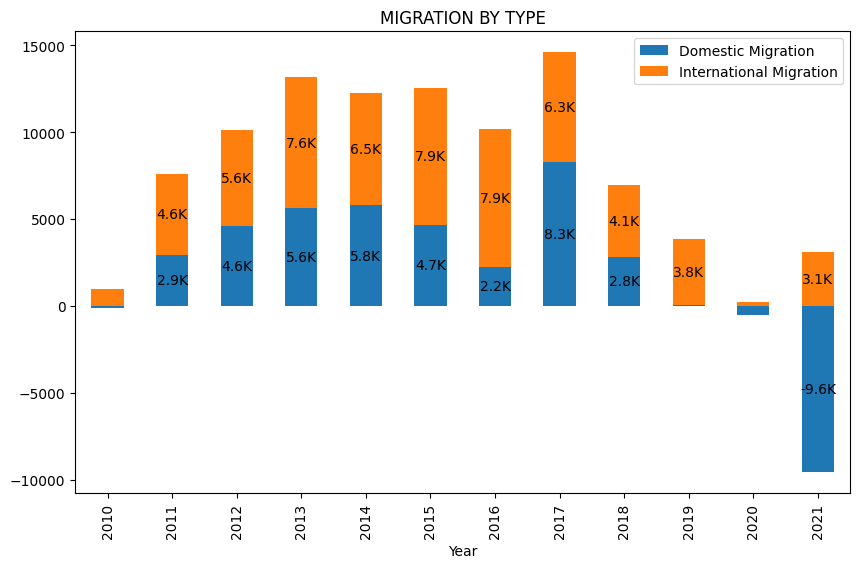

In [29]:
# Pivot the DataFrame to have 'Year' as the index, 'ChangeType' as the columns, and 'PopChange' as the values
pivoted_migration_data = migration_data_sorted.pivot(index='Year', columns='ChangeType', values='PopChange').fillna(0)

# Rename the columns for the legend
pivoted_migration_data.columns = ['Domestic Migration', 'International Migration']

# Plot the stacked bar chart
ax=pivoted_migration_data.plot(kind='bar', stacked=True, figsize=(10, 6))

# Adding labels to each bar, omitting labels for values less than 1.5K
for container in ax.containers:
    labels = [f'{x/1000:.1f}K' if abs(x) >= 1500 else '' for x in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='center')
plt.title('MIGRATION BY TYPE')

# Show the plot
plt.show()

### Creating stacked bar chart for population change type

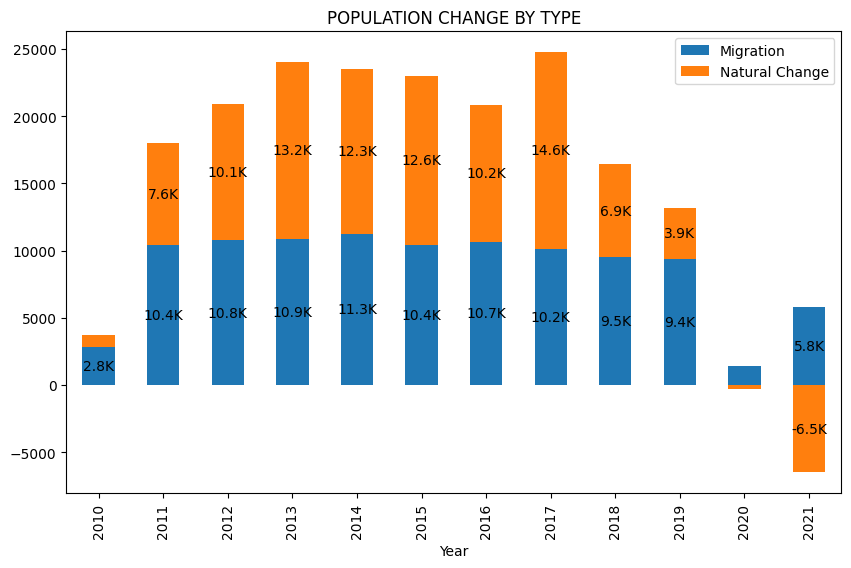

In [30]:
# Pivot the DataFrame to have 'Year' as the index, 'ChangeType' as the columns, and 'PopChange' as the values
pivoted_popChange_data = popChange_data_sorted.pivot(index='Year', columns='ChangeType', values='PopChange').fillna(0)

# Rename the columns for the legend
pivoted_popChange_data.columns = ['Migration', 'Natural Change']

# Plot the stacked bar chart
ax= pivoted_popChange_data.plot(kind='bar', stacked=True, figsize=(10, 6))

# Adding labels to each bar, omitting labels for values less than 1.5K
for container in ax.containers:
    labels = [f'{x/1000:.1f}K' if abs(x) >= 1500 else '' for x in container.datavalues]
    ax.bar_label(container, labels=labels, label_type='center')

plt.title('POPULATION CHANGE BY TYPE')

# Show the plot
plt.show()